In [1]:
import os
from typing import Tuple
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
from getdist import plots, MCSamples
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

save_plots = False

if save_plots:
    os.makedirs('plots', exist_ok=True)

In [2]:
def prob_template_given_mag(fraction: float, kt: float, magnitude: float) -> float:
    """
    Calculates the probability of the template given the magnitude. See equation in Benitez (2000).

    | Spectral type | Fraction | kt    |
    |---------------|----------|-------|
    | E/SO          | 0.35     | 0.147 |
    | Spirals       | 0.50     | 0.450 |
    | Irregulars    | 0.15     |       |

    Args:
        fraction (float): the fraction of each type of object.
        kt (float): a parameter in the equation.
        magnitude (float): the magnitude value

    Returns:
        float: the population of each type.
    """

    if magnitude > 32.0:
        magnitude = 32.0 + 1e-32
    if magnitude < 20.0:
        magnitude = 20.0 + 1e-32

    expterm = kt * (magnitude - 20.0)
    return fraction * np.exp(-expterm)


def prob_redshift_given_template_mag(
    redshift: np.ndarray,
    magnitude: float,
    alpha: float,
    redshift_ref: float,
    kmt: float,
) -> np.ndarray:
    """
    Calculates the pdf of redshift given magnitude and template. See Benitez (2000).

    | Spectral type | alpha  | redshift reference | kmt    |
    |---------------|--------|--------------------|--------|
    | E/SO          | 2.465  | 0.431              | 0.0913 |
    | Spirals       | 1.806  | 0.390              | 0.0636 |
    | Irregulars    | 0.906  | 0.0626             | 0.123  |

    Args:
        redshift (np.ndarray): the redshift on a grid within two limits, for example, 0 and 3.
        magnitude (float): the magnitude of the object.
        alpha (float): a parameter in the equation (depends on the object type).
        redshift_ref (float): another parameter in the equation.
        kmt (float): another parameter in the equation.

    Returns:
        np.ndarray: the normalised pdf of redshift given magnitude and type.
    """
    if magnitude > 32.0:
        magnitude = 32.0 + 1e-32
    if magnitude < 20.0:
        magnitude = 20.0 + 1e-32

    zmt = redshift_ref + kmt * (magnitude - 20)
    probability = redshift**alpha * np.exp(-((redshift / zmt) ** alpha))
    norm = np.trapz(probability, redshift)
    probability = probability / norm
    return probability


def prob_redshift_given_mag(redshift: np.ndarray, magnitude: float) -> np.ndarray:
    """
    Calculates the probability of redshift given magnitude. This is marginalised over templates.

    Args:
        redshift (np.ndarray): the redshift on a grid.
        magnitude (float): the magnitude value.

    Returns:
        np.ndarray: the normalised probability distribution.
    """
    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)

    probability_eso = prob_redshift_given_template_mag(
        redshift, magnitude, 2.465, 0.431, 0.0913
    )
    probability_spi = prob_redshift_given_template_mag(
        redshift, magnitude, 1.806, 0.390, 0.0636
    )
    probability_irr = prob_redshift_given_template_mag(
        redshift, magnitude, 0.906, 0.0626, 0.123
    )

    probability = (
        p_temp_eso * probability_eso
        + p_temp_spi * probability_spi
        + p_temp_irr * probability_irr
    )
    probability = probability / np.trapz(probability, redshift)
    return probability


# Plot Distributions

In [3]:
# the fine bin for redshift 
z_grid_binsize = 0.001
zmin = 1E-5
zmax = 3.0
z_grid_edges = np.arange(zmin, zmax, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# the magnitude
magnitude = 22.0 

In [4]:
p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
p_temp_irr = 1 - (p_temp_eso + p_temp_spi)

In [5]:
probability_eso = prob_redshift_given_template_mag(z_grid, 22, 2.465, 0.431, 0.0913)
probability_spi = prob_redshift_given_template_mag(z_grid, 22, 1.806, 0.390, 0.0636)
probability_irr = prob_redshift_given_template_mag(z_grid, 22, 0.906, 0.0626, 0.123)
prob_z_given_mag = prob_redshift_given_mag(z_grid, 22)

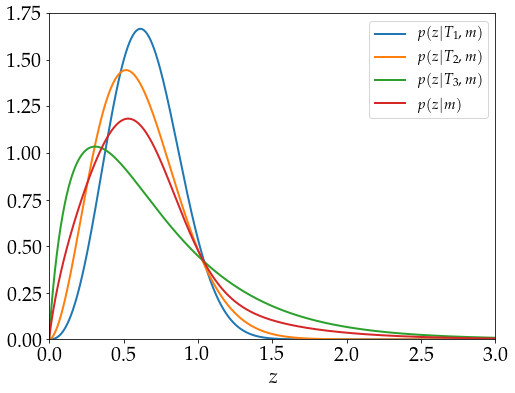

In [6]:
plt.figure(figsize = (8,6))
plt.plot(z_grid, probability_eso, lw = 2, label = r'$p(z|T_{1}, m)$')
plt.plot(z_grid, probability_spi, lw = 2, label = r'$p(z|T_{2}, m)$')
plt.plot(z_grid, probability_irr, lw = 2, label = r'$p(z|T_{3}, m)$')
plt.plot(z_grid, prob_z_given_mag, lw = 2, label = r'$p(z|m)$')
plt.xlim(min(z_grid)-0.001, max(z_grid)+0.002)
plt.ylim(0, 1.75)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

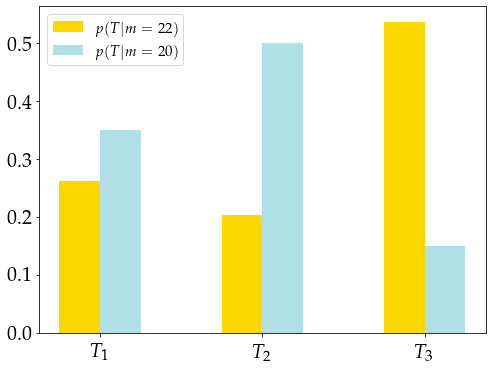

In [7]:
barWidth = 0.25
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8,6))
plt.bar(br1, [p_temp_eso, p_temp_spi, p_temp_irr], width = barWidth, label = r'$p(T|m=22)$', color = 'gold')
plt.bar(br2, [0.35, 0.50, 0.15], width = barWidth, label = r'$p(T|m=20)$',  color = 'powderblue')
plt.xticks([r + 0.5*barWidth for r in range(3)], [r'$T_{1}$', r'$T_{2}$', r'$T_{3}$'])
plt.tick_params(axis='x', labelsize=fontSize, pad=10)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Filters

In [8]:
def interpolate_filters(folder: str, nwave: int = 1000) -> dict:
    """
    Interpolate the filters on a common wavelength. We first record the minimum and
    maximum of each filter and we find the minimum of minimum and maximum of maximum.
    We then output a dictionary which contains the filters and the interpolated wavelengths.

    Args:
        folder (str): name of the folder where the filters are stored.
        nwave (int, optional): number of wavelength between the minimum and maximum. Defaults to 1000.

    Returns:
        dict: a dictionary with the filters and the intepolated wavelength.
    """
    fnames = os.listdir(folder)
    filters = dict()
    filters_int = dict()
    record_min = list()
    record_max = list()
    for file in fnames:
        filterband = np.loadtxt(f"{folder}/{file}")[:, [0, 1]]
        wavelength = filterband[:, 0]
        record_min.append(min(wavelength))
        record_max.append(max(wavelength))
        filters[file.split(".")[0]] = filterband

    minwave = min(record_min)
    maxwave = max(record_max)
    waveint = np.linspace(minwave, maxwave, nwave)

    for key, value in filters.items():
        func = interp1d(
            value[:, 0],
            value[:, 1],
            bounds_error=False,
            kind="linear",
            fill_value=(value[:, 1][0], value[:, 1][-1]),
        )
        ynew = func(waveint)
        filters_int[key] = ynew
    filters_int["wavelength"] = waveint
    return filters_int


In [9]:
filters_int = interpolate_filters('filters', 1000)

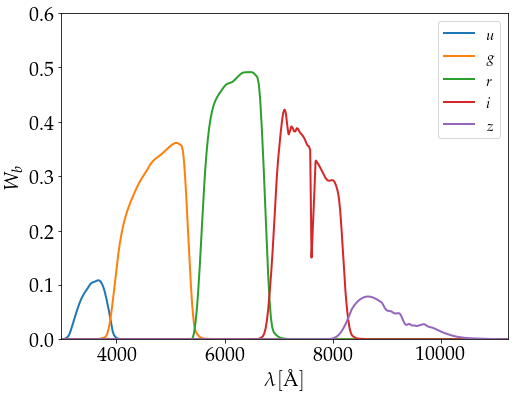

In [10]:
plt.figure(figsize = (8, 6))
plt.plot(filters_int['wavelength'], filters_int['u'], label = r'$u$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['g'], label = r'$g$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['r'], label = r'$r$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['i'], label = r'$i$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['z'], label = r'$z$', lw = 2)
plt.ylim(0.0, 0.6)
plt.xlim(min(filters_int['wavelength']), max(filters_int['wavelength']))
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$W_{b}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
if save_plots:
    plt.savefig('plots/filters.pdf', bbox_inches = 'tight')
plt.show()

# Templates

In [11]:
def process_templates(
    folder: str, waverange: list, nwave: int = 1000, normwave=7e3
) -> dict:
    """
    Process the templates/seds in such a way that they have a common wavelength.

    Args:
        folder (str): the folder where the templates/seds are stored.
        waverange (list): the minimum and maximum of the wavelength.
        nwave (int, optional): the number of wavelengths to use in between. Defaults to 1000.
        normwave (float, optional): the wavelength at which the templates are normalised. Defaults to 7E3.

    Returns:
        dict: a dictionary with the templates and the interpolated wavelengths.
    """
    waveint = np.linspace(waverange[0], waverange[1], nwave)
    templates = dict()
    seds = os.listdir(folder)
    for f in seds:
        file = np.loadtxt(os.path.join(folder, f))
        wavelength = file[:, 0]
        sed = file[:, 1] * file[:, 0] ** 2 / 3e18
        norm_constant = np.interp(normwave, wavelength, sed)
        sed = sed / norm_constant
        func = interp1d(
            wavelength,
            sed,
            bounds_error=False,
            kind="linear",
            fill_value=(sed[0], sed[-1]),
        )
        ynew = func(waveint)
        templates[f.split(".")[0]] = ynew
    templates["wavelength"] = waveint
    return templates


In [12]:
# filenames for the templates 
template_fnames = os.listdir('seds/')
templatenames = [f.split('.')[0] for f in template_fnames]

# process templates 
waverange = (filters_int['wavelength'][0], filters_int['wavelength'][-1])
templates = process_templates('seds/', waverange, 1000, 4.5E3)

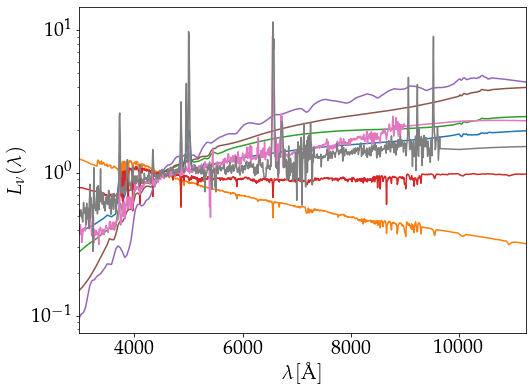

In [13]:
plt.figure(figsize=(8,6))
for fname in templatenames:
    plt.plot(templates['wavelength'], templates[fname])
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$L_{\nu}(\lambda)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(waverange[0], waverange[1])
plt.yscale('log')
if save_plots:
    plt.savefig('plots/templates.pdf', bbox_inches = 'tight')
plt.show()

# Example of Magnitude Distribution

In [14]:
def imagnitude_distribution(
    mgrid: np.ndarray,
    alpha: float = 15.0,
    beta: float = 2.0,
    maglim: float = 24.0,
    offset: float = 1.0,
) -> np.ndarray:
    """
    Generates the distribution for the magnitude (using i here).

    Args:
        mgrid (np.ndarray): the grid of magnitude to consider.
        alpha (float, optional): parameter in the model. Defaults to 15.0.
        beta (float, optional): parameter in the model. Defaults to 2.0.
        maglim (float, optional): magnitude limit. Defaults to 24.0.
        offset (float, optional): an offset parameter. Defaults to 1.0.

    Returns:
        np.ndarray: the normalised probability distribution of the magnitude
    """
    probability = mgrid**alpha * np.exp(-((mgrid / (maglim - offset)) ** beta))
    normalisation = np.trapz(probability, mgrid)
    probability /= normalisation
    return probability


def imagnitude_error_distribution(
    magnitudes: np.ndarray,
    param_a: float = 4.56,
    param_b: float = 1.0,
    param_k: float = 1.0,
    maglim: float = 24.0,
    sigmadet: float = 5.0,
) -> np.ndarray:
    """
    Error distribution for the magnitudes. Following Rykoff et al. 2015.

    Args:
        magnitudes (np.ndarray): the magnitudes.
        param_a (float, optional): a parameter in the model. Defaults to 4.56.
        param_b (float, optional): a parameter in the model. Defaults to 1.0.
        param_k (float, optional): a parameter in the model. Defaults to 1.0.
        maglim (float, optional): the magnitude limit. Defaults to 24.0.
        sigmadet (float, optional): level of sigma detection. Defaults to 5.0.

    Returns:
        np.ndarray: the magnitude error.
    """
    teff = np.exp(param_a + param_b * (maglim - 21.0))
    flux = 10 ** (-0.4 * (magnitudes - 22.5))
    flim = 10 ** (-0.4 * (maglim - 22.5))
    fnoise = (flim / sigmadet) ** 2 * param_k * teff - flim
    sigma_m = (
        2.5 / np.log(10) * np.sqrt((1.0 + fnoise / flux) / (flux * param_k * teff))
    )
    return sigma_m


def draw_samples_one_dim(
    pdf: np.ndarray, grid: np.ndarray, nsamples: int
) -> np.ndarray:
    """
    Draw samples from a one-dimensional pdf.

    Args:
        pdf (np.ndarray): the probability density function.
        grid (np.ndarray): the support.
        nsamples (int): the number of samples we want

    Returns:
        np.ndarray: the samples.
    """
    cdf = np.cumsum(pdf)
    cdf /= np.max(cdf)
    uniform = np.random.uniform(0, 1, nsamples)
    func = interp1d(cdf, grid, bounds_error=False)
    samples = func(uniform)
    return samples


def analytical_error_distribution(
    probability_imag: np.ndarray, mgrid: np.ndarray, maglim: float = 24.0
) -> np.ndarray:
    """
    Get an analytical error distribution for the magnitude given the pdf of the magnitude.

    Args:
        probability_imag (np.ndarray): the probability distribution (pdf) of the magnitude.
        mgrid (np.ndarray): the support for the magnitude.
        maglim (float, optional): the magnitude limit. Defaults to 24.0.

    Returns:
        np.ndarray: the new pdf error magnitude based on the magnitude limit.
    """
    detprob = np.copy(probability_imag)
    ind = mgrid >= maglim - 0.4
    detprob[ind] *= np.exp(-0.5 * ((mgrid[ind] - maglim + 0.4) / 0.2) ** 2)
    normalisation = np.trapz(detprob, mgrid)
    detprob /= normalisation
    return detprob

In [15]:
# grid for i magnitude
imag_grid = np.linspace(17, 26, num=1000)  

# distribution for the i magnitude.
p_imag = imagnitude_distribution(imag_grid)

In [16]:
# Large number of objects to be generated.
nobj = 100000
imags = draw_samples_one_dim(p_imag, imag_grid, nobj) # draw_mag(nobj, imag_grid, p_imag)
imagerrs = imagnitude_error_distribution(imags) # imag_err(imags, maglim) 
imagswitherr = imags + imagerrs*np.random.randn(nobj)

In [17]:
# Doing SNR cut - keep galaxies detected at 5 sigma only
ind = (1./imagerrs > 5.) 
imags_cut = imags[ind]
imagerrs_cut = imagerrs[ind]
imagswitherr_cut = imagswitherr[ind]

In [18]:
analytical_error = analytical_error_distribution(p_imag, imag_grid)

# Sample from $p(m_{i})$

In [19]:
NBINS = 30

Error distribution for the $i$ magnitude. 

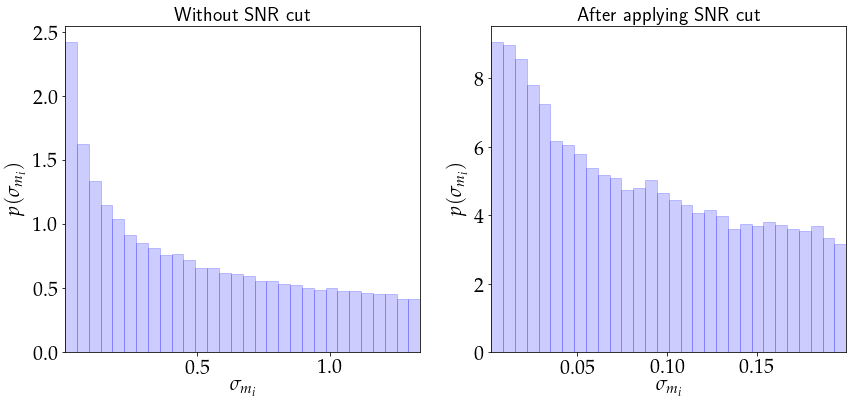

In [20]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.title('Without SNR cut', fontsize=fontSize)
plt.hist(imagerrs, density=True, bins=NBINS, edgecolor='b', color = 'b', alpha = 0.2)
plt.xlim(min(imagerrs), max(imagerrs))
plt.xlabel(r'$\sigma_{m_{i}}$', fontsize = fontSize)
plt.ylabel(r'$p(\sigma_{m_{i}})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)

plt.subplot(122)
plt.title('After applying SNR cut', fontsize=fontSize)
plt.hist(imagerrs_cut, density=True, bins=NBINS, edgecolor='b', color = 'b', alpha = 0.2)
plt.xlim(min(imagerrs_cut), max(imagerrs_cut))
plt.xlabel(r'$\sigma_{m_{i}}$', fontsize = fontSize)
plt.ylabel(r'$p(\sigma_{m_{i}})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

Distribution for the $m_{i}$, with/without cut-off (SNR). 

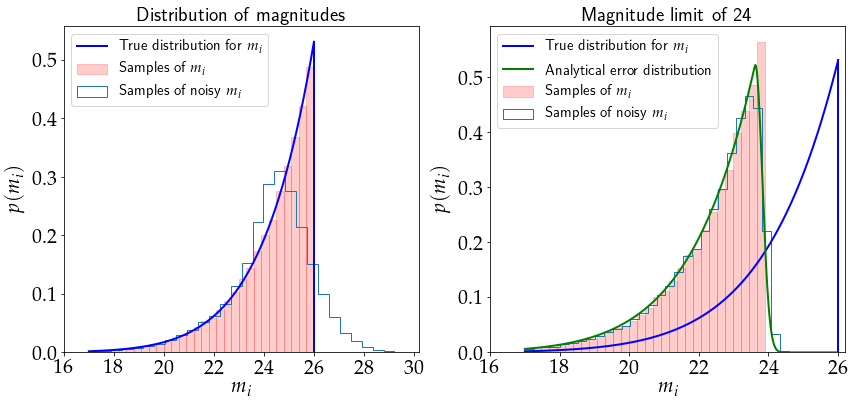

In [21]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.title('Distribution of magnitudes', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 30.2, 2))
plt.xlim(16, 30.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.subplot(122)
plt.title('Magnitude limit of 24', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot(imag_grid, analytical_error, lw = 2, c = 'g', label = 'Analytical error distribution')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags_cut, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr_cut, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 26.2, 2))
plt.xlim(16, 26.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Sample redshift

In [22]:
def pdf_redshift(
    magnitude: float, redshift: np.ndarray, template_ref: str = "eso"
) -> np.ndarray:
    """
    Generates the redshift distribution based on magnitude and the reference template.

    Args:
        magnitude (float): the magnitude value.
        redshift (np.ndarray): the grid of redshift.
        template_ref (str, optional): the reeference template. Can also set to 'marg' if we want the
        marginalised redshift distribution. Defaults to 'eso'.

    Returns:
        np.ndarray: the probability density function.
    """

    assert template_ref in [
        "eso",
        "spi",
        "irr",
        "marg",
    ], "template reference should be one of eso, spi, irr, marg"

    if template_ref == "eso":
        pdf = prob_redshift_given_template_mag(
            redshift, magnitude, 2.465, 0.431, 0.0913
        )
    elif template_ref == "spi":
        pdf = prob_redshift_given_template_mag(
            redshift, magnitude, 1.806, 0.390, 0.0636
        )
    elif template_ref == "irr":
        pdf = prob_redshift_given_template_mag(
            redshift, magnitude, 0.906, 0.0626, 0.123
        )
    else:
        pdf = prob_redshift_given_mag(redshift, magnitude)
    return pdf


def sample_redshift(
    magnitude: float, redshift: np.ndarray, template_ref: str = "eso"
) -> np.ndarray:
    """
    Generate a sample of redshift given the support and the reference template.

    Args:
        magnitude (float): the value of magnitude.
        redshift (np.ndarray): the support for the redshift.
        template_ref (str, optional): the template reference. Defaults to "eso".

    Returns:
        np.ndarray: the redshift sample.
    """
    pdf = pdf_redshift(magnitude, redshift, template_ref)
    sample = draw_samples_one_dim(pdf, redshift, 1)
    return sample

In [23]:
nobj_cut = 10000 # len(imags_cut)

In [24]:
%%time
redshift_eso = np.array([pdf_redshift(imags_cut[i], z_grid, 'eso') for i in range(nobj_cut)])
redshift_spi = np.array([pdf_redshift(imags_cut[i], z_grid, 'spi') for i in range(nobj_cut)])
redshift_irr = np.array([pdf_redshift(imags_cut[i], z_grid, 'irr') for i in range(nobj_cut)])
redshift_marg = np.array([pdf_redshift(imags_cut[i], z_grid, 'marg') for i in range(nobj_cut)])

CPU times: user 7.63 s, sys: 90.6 ms, total: 7.73 s
Wall time: 7.73 s


In [25]:
%%time
sample_redshift_eso = np.array([sample_redshift(imags_cut[0], z_grid, 'eso') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_spi = np.array([sample_redshift(imags_cut[0], z_grid, 'spi') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_irr = np.array([sample_redshift(imags_cut[0], z_grid, 'irr') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_marg = np.array([sample_redshift(imags_cut[0], z_grid, 'marg') for i in range(nobj_cut)]).reshape(-1)

CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 11 s


In [26]:
data_eso = np.array([sample_redshift_eso, imags_cut[0:nobj_cut]]).T
data_spi = np.array([sample_redshift_spi, imags_cut[0:nobj_cut]]).T
data_irr = np.array([sample_redshift_irr, imags_cut[0:nobj_cut]]).T
data_marg = np.array([sample_redshift_marg, imags_cut[0:nobj_cut]]).T

In [27]:
def generate_2d_plot(
    samples: np.ndarray, name: str = "E/SO"
) -> plots.GetDistPlotter:
    """
    Generates a 2D density plot of the samples of redshift and magnitudes. The first column contains the redshift
    while the second column contains the magnitudes.

    Args:
        samples (np.ndarray): the redshift and magnitude samples.
        name (str, optional): the name of the template type. Defaults to "E/SO".

    Returns:
        getdist.plots.GetDistPlotter: the getdist plot.
    """
    ndim = samples.shape[1]
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$z$", r"$m_{i}$"]
    samps = MCSamples(
        samples=samples,
        names=names,
        labels=labels,
        ranges={"x0": (0.0, None)},
        settings=settings,
    )
    samps.updateSettings({"contours": [0.68, 0.95, 0.99]})

    ax = plots.get_single_plotter(width_inch=4, ratio=1)
    ax.settings.axes_fontsize = 15
    ax.settings.lab_fontsize = 15
    ax.settings.num_plot_contours = 3
    ax.settings.solid_contour_palefactor = 0.75
    ax.settings.alpha_filled_add = 0.9
    ax.plot_2d(samps, "x0", "x1", filled=True, colors=["red"], lims=[0.0, 4.0, 16, 26])
    ax.add_legend([name], colored_text=True, legend_loc="lower right")
    return ax

In [28]:
def plot_all_samples(
    data_eso: np.ndarray,
    data_spi: np.ndarray,
    data_irr: np.ndarray,
    data_marg: np.ndarray,
) -> None:
    """
    Plot the 2D distribution for the samples obtained from different templates, as well as,
    the one where we marginalise over all the three templates. The first column contains the
    redshift samples and the second column contains the magnitude samples.

    Args:
        data_eso (np.ndarray): the redshift and magnitude samples using the E/SO type template.
        data_spi (np.ndarray): the redshift and magnitude samples using the Spiral type template.
        data_irr (np.ndarray): the redshift and magnitude samples using the Irregular type template.
        data_marg (np.ndarray): the redshift and magnitude samples when the templates are marginalised over.
    """
    newsamples = np.concatenate([data_eso, data_spi, data_irr, data_marg], axis=1)

    limits = {
        "x0": (0.0, None),
        "x1": (16, 26),
        "x2": (0.0, None),
        "x3": (16, 26),
        "x4": (0.0, None),
        "x5": (16, 26),
        "x6": (0.0, None),
        "x7": (16, 26),
    }

    ndim = 8
    names = ["x%s" % i for i in range(ndim)]
    labels = [r"$z$", r"$m_{i}$"] * 4
    samps = MCSamples(
        samples=newsamples, names=names, labels=labels, ranges=limits, settings=settings
    )

    g = plots.get_subplot_plotter(subplot_size=4)
    g.settings.axes_fontsize = 15
    g.settings.lab_fontsize = 15
    g.settings.num_plot_contours = 3
    g.settings.solid_contour_palefactor = 0.75
    g.settings.alpha_filled_add = 0.9
    g.settings.scaling = False
    g.plots_2d(
        samps,
        param_pairs=[["x0", "x1"], ["x2", "x3"], ["x4", "x5"], ["x6", "x7"]],
        nx=2,
        filled=True,
        colors=["blue"],
        lims=[0.0, 4.0, 16, 26],
    )
    plt.show()


In [29]:
def plot_1d_redshift_distributions(
    redshift_grid: np.ndarray, pdfs: list, nselected: int
) -> None:
    """
    Plot samples of the redshift distribution.

    Args:
        redshift_grid (np.ndarray): the redshift support.
        pdfs (list): a list of the redshift distributions
        nselected (int): the number of selected redshift distribution.
    """

    assert (
        nselected < pdfs[0].shape[0]
    ), f"Number of samples to be plotted should be less than {pdfs[0].shape[0]}."

    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.title("E/SO", fontsize=fontSize)
    plt.plot(redshift_grid, pdfs[0][0:nselected].T, lw=0.1)
    plt.xlabel(r"$z$", fontsize=fontSize)
    plt.ylabel(r"$p(z|T_{1}, m)$", fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.5)

    plt.subplot(222)
    plt.title("Spirals", fontsize=fontSize)
    plt.plot(redshift_grid, pdfs[1][0:nselected].T, lw=0.1)
    plt.xlabel(r"$z$", fontsize=fontSize)
    plt.ylabel(r"$p(z|T_{2}, m)$", fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.0)

    plt.subplot(223)
    plt.title("Irregulars", fontsize=fontSize)
    plt.plot(redshift_grid, pdfs[2][0:nselected].T, lw=0.1)
    plt.xlabel(r"$z$", fontsize=fontSize)
    plt.ylabel(r"$p(z|T_{3}, m)$", fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 6.0)

    plt.subplot(224)
    plt.title("Marginalised over templates", fontsize=fontSize)
    plt.plot(redshift_grid, pdfs[3][0:nselected].T, lw=0.1)
    plt.xlabel(r"$z$", fontsize=fontSize)
    plt.ylabel(r"$p(z|m)$", fontsize=fontSize)
    plt.tick_params(axis="x", labelsize=fontSize)
    plt.tick_params(axis="y", labelsize=fontSize)
    plt.xlim(0, 3.0)
    plt.ylim(0, 2.0)

    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.45
    )
    plt.show()

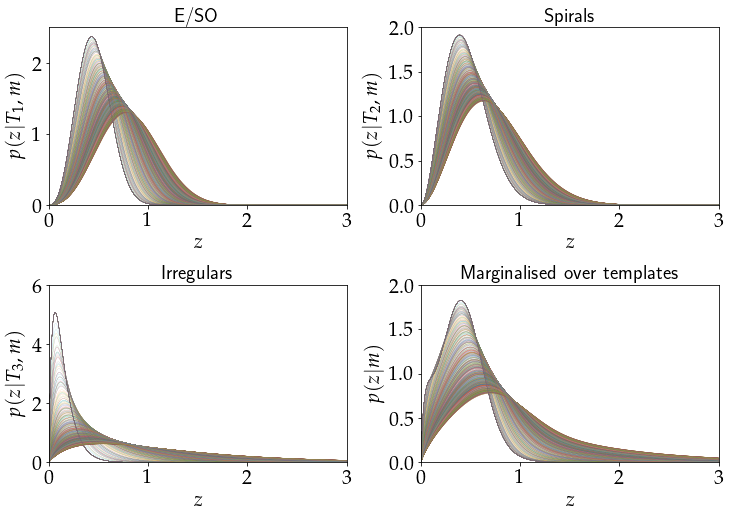

In [30]:
plot_1d_redshift_distributions(z_grid, [redshift_eso, redshift_spi, redshift_irr, redshift_marg], nselected=1000)

Removed no burn in


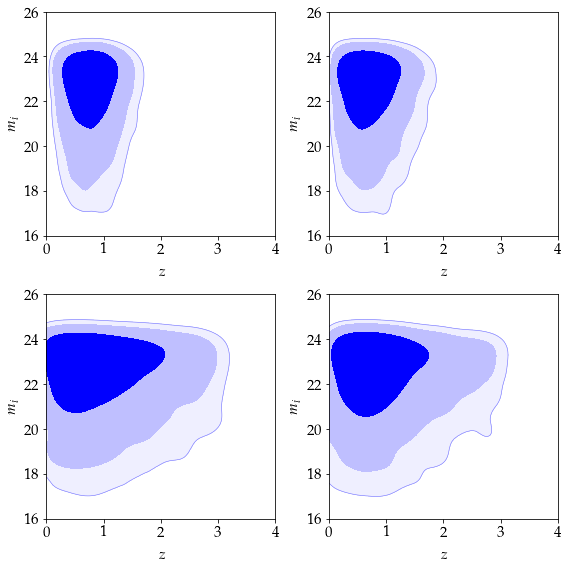

In [31]:
plot_all_samples(data_eso, data_spi, data_irr, data_marg)

# Binning

In [32]:
nbins = 11
bin_z = np.linspace(0, 3, nbins)
bin_m = np.linspace(16, 24, nbins)

In [33]:
data_bin = data_marg

In [34]:
H, z_edges, m_edges, binnumber  = stats.binned_statistic_2d(data_bin[:,0], data_bin[:,1], None, 'count', 
                                                          bins=[bin_z, bin_m], expand_binnumbers=True)

area_2d = np.sum(H * np.outer(np.diff(z_edges), np.diff(m_edges)))
H_norm = H / area_2d

XX, YY = np.meshgrid(z_edges, m_edges)

In [35]:
hist, xedges, yedges = np.histogram2d(data_bin[:,0], data_bin[:,1], bins=(nbins,nbins), range = [[0, 3],[16, 24]])
hist /= np.sum(hist * np.outer(np.diff(xedges), np.diff(yedges)))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

In [36]:
xpos = xpos.flatten()*0.5
ypos = ypos.flatten()*0.5
zpos = np.zeros_like(xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.T.flatten()

In [37]:
cmap = cm.get_cmap('Blues') 
max_height = np.max(dz)   
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 

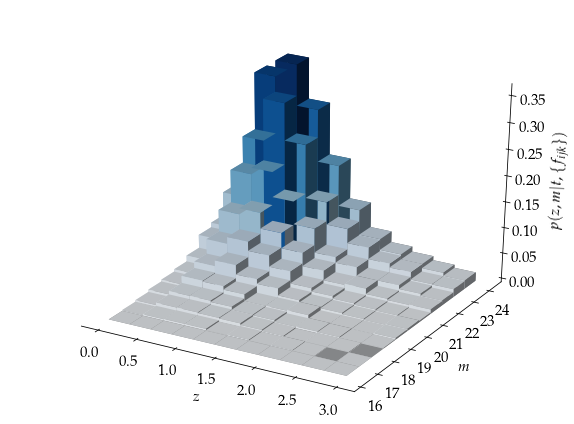

In [38]:
plot_projection = False
font_size = 15

fig = plt.figure(figsize = (16, 6))

# the 2D projection
if plot_projection:
    ax1=fig.add_subplot(121, rasterized=True)
    plot1 = ax1.pcolormesh(XX,YY,H_norm.T, cmap=plt.cm.Blues)
    cbar = plt.colorbar(plot1, fraction = 0.05)
    cbar.ax.tick_params(labelsize=font_size) 
    ax1.set_xlabel(r'$z$', fontsize = font_size)
    ax1.set_ylabel(r'$m$', fontsize = font_size)
    ax1.tick_params(axis='x', labelsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)

# 3D histogram (type is fixed)
ax = fig.add_subplot(122, projection='3d', rasterized=True)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba) 
ax.set_xlabel(r'$z$', fontsize = font_size, labelpad = 10)
ax.set_ylabel(r'$m$', fontsize = font_size, labelpad = 10)
ax.set_zlabel(r'$p(z,m|t,\{f_{ijk}\})$', fontsize=font_size, labelpad = 10)
ax.tick_params(axis='x', labelsize=font_size, pad=5)
ax.tick_params(axis='y', labelsize=font_size, pad=5)
ax.tick_params(axis='z', labelsize=font_size, pad=5)
# ax.view_init(0, 0)

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# remove grid lines
ax.grid(False)

plt.tight_layout()
plt.savefig('plots/2d_histogram.pdf', bbox_inches = 'tight')
plt.show()

# Use SEDs now

In [81]:
def approx_lum_dist(redshift: float) -> float:
    """
    Calculates the approximate luminosity distance given a redshift.

    Args:
        redshift (float): the redshift value.

    Returns:
        float: the approximate luminosity distance.
    """
    return np.exp(30.5 * redshift**0.04 - 21.7)

In [82]:
def get_seds(folder: str, waveref: float = 4e5) -> dict:
    """
    Get the SEDs from the folder and the SEDs are normalised at a particular wavelength.

    Args:
        folder (str): folder where the SEDs are stored.
        waveref (float, optional): the wavelength at which the SEDs are standardised. Defaults to 4e5.

    Returns:
        dict: dictionary with the standardised SEDs.
    """
    sednames = os.listdir(folder)
    seds = dict()
    for i, t in enumerate(sednames):
        seddata = np.genfromtxt(f"{folder}/{t}")
        seddata[:, 1] *= seddata[:, 0] ** 2.0 / 3e18
        ref = np.interp(waveref, seddata[:, 0], seddata[:, 1])
        seddata[:, 1] /= ref
        seds[t.split(".")[0]] = seddata
    return seds

In [83]:
def get_filters(folder: str) -> Tuple[dict, dict, dict]:
    """
    Get the filters to be used to calculate the flux.

    Args:
        folder (str): folder where the filters are stored.

    Returns:
        Tuple[dict, dict, dict]: the filter, its wavelength range, the minimum and maximum wavelength.
    """
    filters = os.listdir(folder)
    record = dict()
    record_wavelength = dict()
    record_minmax = dict()

    for f in filters:
        data = np.genfromtxt(os.path.join(folder, f))
        wavelength, filt = data[:, 0], data[:, 1]
        # the filter is divided by wavelength here
        filt /= wavelength
        norm = np.trapz(filt, wavelength)
        filt /= norm

        # find minimum and maximum wavelength
        ind = np.where(filt > 0.01 * np.max(filt))[0]
        lambda_min, lambda_max = wavelength[ind[0]], wavelength[ind[-1]]

        record[f.split(".")[0]] = filt
        record_minmax[f.split(".")[0]] = [lambda_min, lambda_max]
        record_wavelength[f.split(".")[0]] = wavelength

    return record, record_wavelength, record_minmax

In [84]:
def get_flux(
    filters: dict, wavelengths: dict, lambdaminmax: dict, seds: dict, redshift: float
) -> pd.DataFrame:
    """
    Calculate the theoretical flux. The output is a dataframe of size Nt x Nf,
    where Nt is the number of templates and Nf is the number of filters.

    Args:
        filters (dict): a dictionary of filters.
        wavelengths (dict): a dictionary of the wavelength range.
        lambdaminmax (dict): the minimum and maximum of wavelength.
        seds (dict): a dictionary with all the SEDs/templates.
        redshift (float): the redshift value.

    Returns:
        pd.DataFrame: a dataframe of fluxes for Nt templates and Nf filters.
    """
    scaled_redshift = 1.0 + redshift
    nfilters = len(filters)
    nseds = len(seds)

    # calculate pre-factor
    lum_dist = approx_lum_dist(redshift)
    prefactor = scaled_redshift**2 / (4.0 * np.pi * lum_dist**2)

    # empty array to store the fluxes
    record_fluxes = dict()

    for i, s in enumerate(seds):
        fluxes = np.zeros(nfilters)
        for j, f in enumerate(filters):
            wave_grid = np.linspace(
                lambdaminmax[f][0] / scaled_redshift,
                lambdaminmax[f][1] / scaled_redshift,
                5000,
            )
            filter_interp = interp1d(wavelengths[f] / scaled_redshift, filters[f])
            sed_interp = interp1d(seds[s][:, 0], seds[s][:, 1])
            filter_new = filter_interp(wave_grid)
            sed_new = sed_interp(wave_grid)
            fluxes[j] = prefactor * np.trapz(sed_new * filter_new, wave_grid)
        record_fluxes[s] = fluxes
    record_fluxes = pd.DataFrame(record_fluxes).T
    record_fluxes.columns = filters.keys()
    return record_fluxes

In [85]:
seds = get_seds('seds')
filters, filterwave, filterwaverange = get_filters('filters')

In [86]:
get_flux(filters, filterwave, filterwaverange, seds, 0.002)

,u,g,r,i,z
Im_B2004a,0.000443,0.000839,0.001013,0.001179,0.001307
ssp_5Myr_z008,3.136324,2.656979,1.884955,1.505155,1.203167
Scd_B2004a,0.000396,0.000958,0.001455,0.001742,0.001861
ssp_25Myr_z008,0.282421,0.364836,0.340093,0.339375,0.347663
El_B2004a,0.000540,0.002433,0.004920,0.006855,0.008548
Sbc_B2004a,0.000228,0.000696,0.001189,0.001557,0.001902
SB3_B2004a,0.001392,0.002947,0.004321,0.004602,0.006109
SB2_B2004a,0.003199,0.005256,0.005833,0.005733,0.006731


In [87]:
%%time
fluxgrid = list()
ntest = len(z_grid)
for i in range(ntest):
    fluxcalc = get_flux(filters, filterwave, filterwaverange, seds, z_grid[i])
    fluxgrid.append(np.clip(-2.5 * np.log10(fluxcalc), 1E-5, 1E5))
fluxgrid = np.dstack(fluxgrid)

CPU times: user 28.7 s, sys: 0 ns, total: 28.7 s
Wall time: 28.7 s


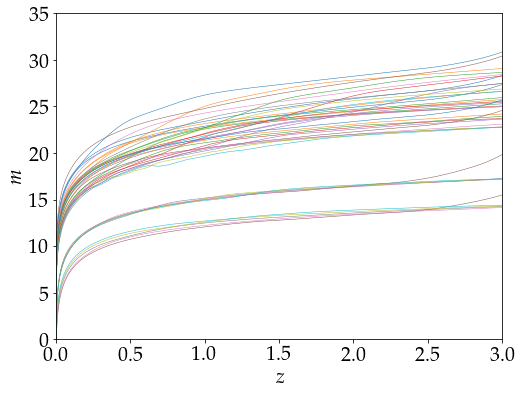

In [88]:
plt.figure(figsize = (8, 6))
nseds = len(seds)
nfilters = len(filters)
for i in range(nseds):
    for j in range(nfilters):
        sedtype = list(seds.keys())[i]
        filtertype = list(filters.keys())[j]
        plt.plot(z_grid, fluxgrid[i, j], lw=0.5)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.ylabel(r'$m$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0, 3.0)
plt.ylim(0, 35)
plt.show()

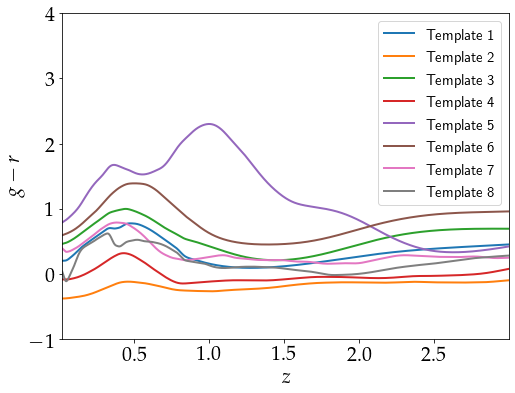

In [89]:
plt.figure(figsize = (8,6))
for i in range(8):
    plt.plot(z_grid, fluxgrid[i, 1, :,] - fluxgrid[i, 2, :,], lw = 2, label = f'Template {i+1}')
plt.xlim(0.02, max(z_grid))
plt.ylim(-1, 4)
plt.ylabel(r'$g-r$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

In [90]:
def sample_mag_sigma(p_imag: np.ndarray, imag_grid: np.ndarray) -> Tuple[float, float]:
    """
    Sample a value of magnitude and its corresponding error. We do this for high signal to noise ratio,
    that is, we set the threshold sigma level to 5.

    Args:
        p_imag (np.ndarray): the pdf of the magnitude.
        imag_grid (np.ndarray): the support for the magnitude.

    Returns:
        Tuple[float, float]: the magnitude sample and a sample of error.
    """
    sigmalevel = 1e-32
    while sigmalevel < 5:
        mag = draw_samples_one_dim(p_imag, imag_grid, 1)
        err = imagnitude_error_distribution(mag)
        sigmalevel = 1 / err
    return mag, err

In [96]:
def sample_template(magnitude: float, template_match: dict) -> Tuple[str, str]:
    """
    Sample a template based on probabilities.

    Args:
        magnitude (float): the magnitude value.
        template_match (dict): a dictionary which describes the nature of the template, for example,

    template_match = {
    'El_B2004a': 'eso',
    'Sbc_B2004a': 'spi',
    'Scd_B2004a': 'spi',
    'Im_B2004a': 'irr',
    'SB3_B2004a': 'irr',
    'SB2_B2004a': 'irr',
    'ssp_25Myr_z008': 'irr',
    'ssp_5Myr_z008': 'irr'
    }

    Returns:
        Tuple[str, str]: the template name and the template type.
    """
    counts = dict(Counter([value[1] for value in template_match.items()]))
    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)
    probabilities = {
        "eso": p_temp_eso / counts["eso"],
        "spi": p_temp_spi / counts["spi"],
        "irr": p_temp_irr / counts["irr"],
    }

    probs = dict()
    for key in template_match.keys():
        if template_match[key] == "eso":
            probs[key] = probabilities["eso"]
        elif template_match[key] == "spi":
            probs[key] = probabilities["spi"]
        else:
            probs[key] = probabilities["irr"]

    probabilities = np.asarray(list(probs.values())).reshape(-1)
    temp_samp = np.random.choice(list(probs.keys()), p=probabilities)
    return temp_samp, template_match[temp_samp]

In [97]:
template_match = {
    'El_B2004a': 'eso', 
    'Sbc_B2004a': 'spi',
    'Scd_B2004a': 'spi',
    'Im_B2004a': 'irr',
    'SB3_B2004a': 'irr',
    'SB2_B2004a': 'irr',
    'ssp_25Myr_z008': 'irr',
    'ssp_5Myr_z008': 'irr'
}

In [98]:
def generate_flux_redshift(p_imag, imag_grid, z_grid, template_match, nobjects):

    record = list()
    record_redshift = list()
    for i in range(nobjects):
        
        # get the magnitude and magnitude error 
        mag, magerr = sample_mag_sigma(p_imag, imag_grid)
        
        # sample the template
        template_sample = sample_template(mag, template_match)
        
        # sample the redshift
        redshift_sample = sample_redshift(mag, z_grid, template_sample[1])
        
        # get a sample of the flux 
        flux_sample = get_flux(filters, filterwave, filterwaverange, seds, redshift_sample[0])
        
        # calculate the magnitude (no error)
        mag_noerr = -2.5 * np.log10(flux_sample.divide(flux_sample['g'], axis = 0)) + mag[0]

        # calculate the error on the magnitude
        err = magerr * (1 + 0.05*np.random.randn(flux_sample.shape[1]))
        
        # calculate a noisy magnitude
        mag_err = mag_noerr.loc[template_sample[0]] + err * np.random.randn(flux_sample.shape[1])

        record.append(mag_err)
        record_redshift.append(redshift_sample)
        
    record = pd.DataFrame(record)
    record_redshift = np.asarray(record_redshift)
    return record, record_redshift

In [99]:
%%time
noisy_fluxes, redshift_samples = generate_flux_redshift(p_imag, imag_grid, z_grid, template_match, 5000)

CPU times: user 49.1 s, sys: 3.99 ms, total: 49.1 s
Wall time: 49.1 s


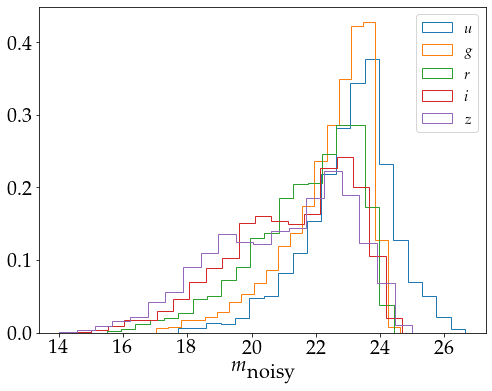

In [100]:
plt.figure(figsize = (8, 6))
plt.hist(noisy_fluxes['u'], density = True, bins = 20, histtype='step', label = r'$u$')
plt.hist(noisy_fluxes['g'], density = True, bins = 20, histtype='step', label = r'$g$')
plt.hist(noisy_fluxes['r'], density = True, bins = 20, histtype='step', label = r'$r$')
plt.hist(noisy_fluxes['i'], density = True, bins = 20, histtype='step', label = r'$i$')
plt.hist(noisy_fluxes['z'], density = True, bins = 20, histtype='step', label = r'$z$')
plt.xlabel(r'$m_{\textrm{noisy}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Plot difference in Colors

In [101]:
temp_chosen = 'Sbc_B2004a'
index = noisy_fluxes.index == temp_chosen
subset = noisy_fluxes[index]
fluxgrid_sub = fluxgrid[list(seds.keys()).index(temp_chosen), :, :,]

In [102]:
keys = ['u', 'g', 'r', 'i', 'z']

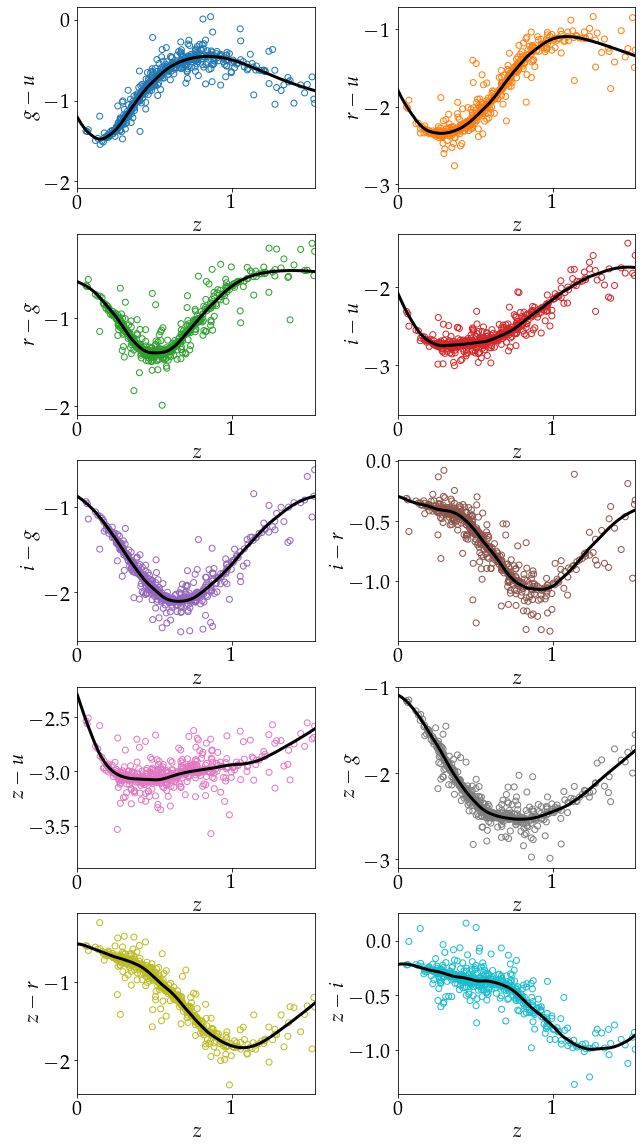

In [103]:
record_pairs = dict()
plt.figure(figsize = (10, 20))
iterindex = 0 
for j in range(5):
    for k in range(j+1):
        key1, key2 = keys[j], keys[k]
        if key1 != key2:
            delta = subset[key1].values - subset[key2].values
            fobs = fluxgrid_sub[j] - fluxgrid_sub[k]
            plt.subplot(5, 2, iterindex + 1)
            color = np.asarray(cm.tab10.colors[iterindex]).reshape(1,-1)
            plt.scatter(redshift_samples[index], delta, color='none', edgecolors= color)
            plt.plot(z_grid, fobs, lw = 3, c = 'k')
            plt.xlim(0, max(redshift_samples[index]))
            plt.ylabel(f'${key1} - {key2}$', fontsize = fontSize)
            plt.xlabel(r'$z$', fontsize = fontSize)
            plt.tick_params(axis='x', labelsize=fontSize)
            plt.tick_params(axis='y', labelsize=fontSize)
            iterindex += 1
            record_pairs[f'{key1}-{key2}'] = delta
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.25)
plt.show()

In [104]:
list(record_pairs.keys())

['g-u', 'r-u', 'r-g', 'i-u', 'i-g', 'i-r', 'z-u', 'z-g', 'z-r', 'z-i']

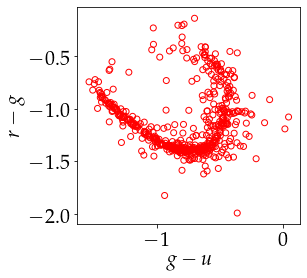

In [105]:
# g-r, u-g
plt.figure(figsize=(4,4))
plt.scatter(record_pairs['g-u'], record_pairs['r-g'], color='none', edgecolors= 'r')
plt.xlabel(r'$g-u$', fontsize = fontSize)
plt.ylabel(r'$r-g$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Binning in 1D

This is without drawing samples. 

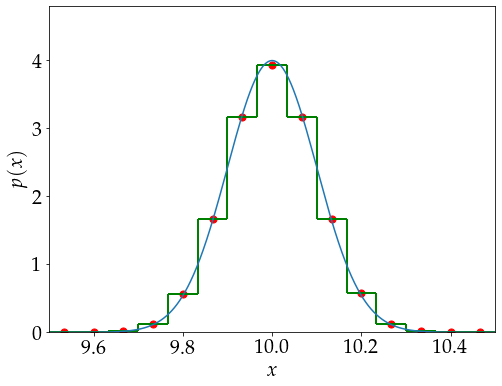

In [106]:
ncoarse = 16
nfine = 1000
mean = 10 
std = 0.1
xmin = mean-5*std
xmax = mean+5*std

normal = stats.norm(mean, std)
xfine = np.linspace(xmin, xmax, nfine)
yfine = normal.pdf(xfine)
xbin = np.linspace(xmin, xmax, ncoarse)
bin_means, bin_edges, binnumber = stats.binned_statistic(xfine, yfine, statistic='mean', bins=xbin)
xbin_mid = bin_edges[:-1] + 0.5 * np.diff(bin_edges)

plt.figure(figsize = (8,6))
plt.plot(xfine, yfine)
plt.scatter(xbin_mid, bin_means, s = 50, c = 'r')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2)
plt.vlines(bin_edges[1:-1], bin_means[:-1], bin_means[1:], colors='g', lw=2)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.ylabel(r'$p(x)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(xfine), max(xfine))
plt.ylim(0, 1.2*max(yfine))
plt.show()

If we instead draw samples.

In [107]:
# statistics, edges, binnumber
sample_method = stats.binned_statistic(normal.rvs(5000), None, statistic='count', bins=xbin)

In [108]:
counts = sample_method[0]
delta = np.diff(sample_method[1])
area = sum(counts * delta)
heights = counts/area

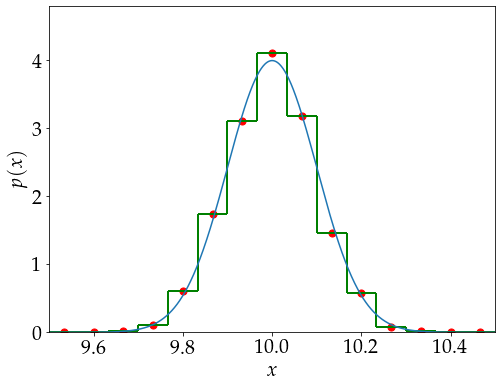

In [109]:
plt.figure(figsize = (8,6))
plt.plot(xfine, yfine)
plt.scatter(xbin_mid, heights, s = 50, c = 'r')
plt.hlines(heights, sample_method[1][:-1], sample_method[1][1:], colors='g', lw=2)
plt.vlines(sample_method[1][1:-1], heights[:-1], heights[1:], colors='g', lw=2)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.ylabel(r'$p(x)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(xfine), max(xfine))
plt.ylim(0, 1.2*max(yfine))
plt.show()

# Dirichlet Method 

We can use Dirichlet method to find the heights of the individual bins. 

<img src="figures/dirichlet.png" width="600" height="300">

In [110]:
def dirichlet(rsize, alphas):
    gammabs = np.array([np.random.gamma(alpha + 1, size=rsize) for alpha in alphas])
    fbs = gammabs / gammabs.sum(axis=0)
    return fbs.T

In [111]:
# statistics, edges, binnumber
samples = normal.rvs(5000)
counts, edges, binnumber = stats.binned_statistic(samples, None, statistic='count', bins=xbin)

In [112]:
dirichlet_samples = dirichlet(5000, counts) 

In [113]:
mean_dirichlet = np.mean(dirichlet_samples, axis = 0)
std_dirichlet = np.std(dirichlet_samples, axis = 0)
delta = np.diff(edges)

In [114]:
heights = mean_dirichlet/delta
heights_sigma = std_dirichlet/delta

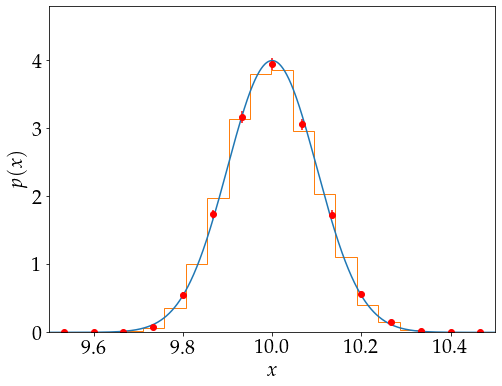

In [115]:
plt.figure(figsize = (8, 6))
plt.plot(xfine, yfine)
plt.hist(samples, density=True, bins=ncoarse-1, histtype='step')
plt.errorbar(xbin_mid, heights, yerr = heights_sigma, fmt = 'ro')
plt.xlabel(r'$x$', fontsize = fontSize)
plt.ylabel(r'$p(x)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(xfine), max(xfine))
plt.ylim(0, 1.2*max(yfine))
plt.show()

# Binning in 2D

In [116]:
redshift = np.linspace(0, 3, 1000)
magnitude = np.linspace(16, 26, 1000) 

samples_redshift = stats.norm(1, 0.2).rvs(1000)
samples_magnitude = stats.norm(20, 1).rvs(1000)

bin_z = np.linspace(0, 3, 20)
bin_m = np.linspace(16, 26, 15)

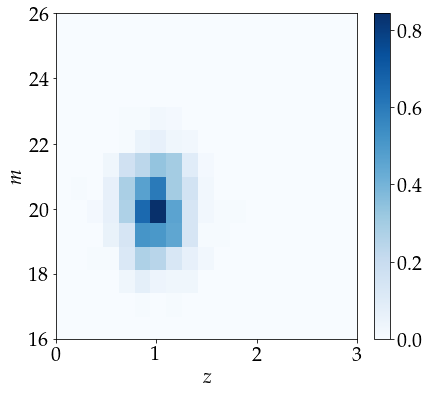

In [117]:
H, z_edges, m_edges, binnumber  = stats.binned_statistic_2d(samples_redshift, samples_magnitude, None, 'count', 
                                                          bins=[bin_z, bin_m], expand_binnumbers=True)

area_2d = np.sum(H * np.outer(np.diff(z_edges), np.diff(m_edges)))
H_norm = H / area_2d

XX, YY = np.meshgrid(z_edges, m_edges)

fig = plt.figure(figsize = (6,6))
ax1=plt.subplot(111)
plot1 = ax1.pcolormesh(XX,YY,H_norm.T, cmap=plt.cm.Blues, rasterized=True)
cbar = plt.colorbar(plot1, fraction = 0.05)
cbar.ax.tick_params(labelsize=fontSize) 
plt.xlabel(r'$z$', fontsize = fontSize)
plt.ylabel(r'$m$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Understand Gibbs sampling

This is purely a hypothetical example.

In [118]:
import scipy.stats as ss 
import numpy as np 
from itertools import product

In [119]:
def dirichlet(rsize, alphas):
    gammabs = np.array([np.random.gamma(alpha + 1, size=rsize) for alpha in alphas])
    fbs = gammabs / gammabs.sum(axis=0)
    return fbs.T

In [120]:
nobj = 5000
nz = 20
nm = 10
nbins = nz * nm

In [121]:
ibins = np.repeat(np.arange(1, nbins), nobj).reshape((nbins - 1, nobj)).T.ravel()

In [122]:
x = np.linspace(-5, 5, nz)
y = np.linspace(-5, 5, nm)

In [123]:
pdfints = list()
for i in range(nobj):
    pairs = np.array(list(product(x, y)))
    dist = ss.multivariate_normal(2*np.random.randn(2), np.eye(2))
    pdfint = dist.pdf(pairs)
    pdfints.append(pdfint)

In [124]:
pdfints = np.asarray(pdfints)

Random initialisation of the number of particles within each cell. This should probably be random integers (rather than float). Doesn't matter - we can ignore the first few recorded samples (burnin).

In [125]:
nbs = np.random.rand(nbins)

In [126]:
record_nbs = list()
record_hbs = list()

In [127]:
nsamples = 2000
burnin = 0.1

This piece of code (from Boris) is essentially throwing $N$ objects randomly in a 3D space, and is simply counting the number of objects which are found in cell $ijk$. He does not count those with low probabilities. I guess, this will unecessarily lead to a peak in the final distribution. 

In [128]:
for i in range(nsamples):
    hbs = dirichlet(1, nbs) 
    prods = pdfints * hbs

    cumsumweights = np.add.accumulate(prods, axis=1).T  
    cumsumweights /= cumsumweights[-1, :]
    
    pos = np.random.uniform(0.0, 1.0, size=nobj)
    cond = np.logical_and(pos > cumsumweights[:-1, :], pos <= cumsumweights[1:, :])
    res = np.zeros(nobj, dtype=int)
    res[pos <= cumsumweights[0, :]] = 0
    locs = np.any(cond, axis=0)
    res[locs] = ibins[cond.T.ravel()]
    ind_inrange = np.logical_and(res > 0, res < nbins)
    nbs = np.bincount(res[ind_inrange], minlength=nbins)
    
    record_nbs.append(nbs)
    record_hbs.append(hbs)

In [129]:
record_nbs = np.asarray(record_nbs)
record_hbs = np.asarray(record_hbs)

In [130]:
record_nbs = record_nbs.reshape(nsamples, nz, nm)[int(burnin * nsamples):]
record_hbs = record_hbs.reshape(nsamples, nz, nm)[int(burnin * nsamples):]

In [131]:
# marginalise over the second dimension (for example magnitude)
hist_nz = record_hbs.sum(axis = 2)
hist_nm = record_hbs.sum(axis = 1)

In [132]:
mean_nz = np.mean(hist_nz, axis = 0)
mean_nm = np.mean(hist_nm, axis = 0)

std_nz = np.std(hist_nz, axis = 0)
std_nm = np.std(hist_nm, axis = 0)

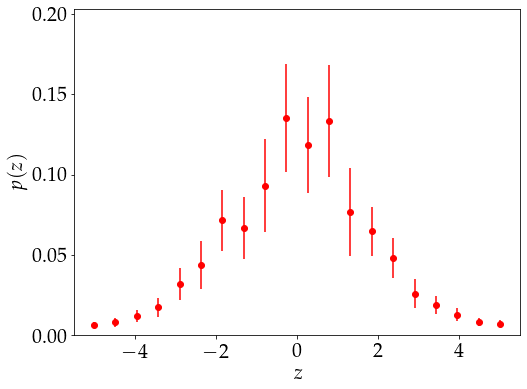

In [133]:
plt.figure(figsize=(8,6))
plt.errorbar(x, mean_nz, yerr=std_nz, fmt = 'ro')
plt.xlabel(r'$z$', fontsize = fontSize)
plt.ylabel(r'$p(z)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 1.5*max(mean_nz))
plt.show()

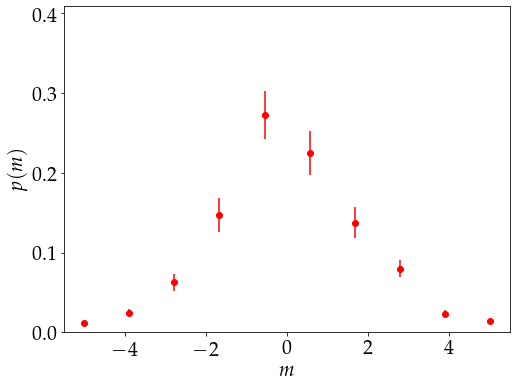

In [134]:
plt.figure(figsize=(8,6))
plt.errorbar(y, mean_nm, yerr=std_nm, fmt = 'ro')
plt.xlabel(r'$m$', fontsize = fontSize)
plt.ylabel(r'$p(m)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 1.5*max(mean_nm))
plt.show()

# Algorithm

- Keep the main code as it is (but think about how to generalise it to any number of fine, coarse bins). 
- The memory issue arises due to the fact we are working with big tensors: $N_{obj}\times N_{z}\times N_{t}\times N_{m}$. If $N_{obj}>10000$, this is a very huge tensor. Use 16 floating point instead of 32 or 64?  
- Ideally, we want a single $N(z)$ distribution (hence a single distribution of the cosmological parameters). We can build something along this line. Split the data into $N_{batch}$. For each batch, repeat Boris' code, but store the Gibbs samples for the full dataset. 

In [135]:
test = np.random.rand(1, 3000, 50, 1000).astype(np.float16)

In [136]:
nobj = int(1e5)

In [137]:
print(f'Size of array is: {test.nbytes * 1e-9 * nobj:.2f} GB for {nobj} objects.')

Size of array is: 30000.00 GB for 100000 objects.


If we use binning, say we have 75 redshift bins and 50 magnitude bins. 

In [142]:
test_bin = np.random.rand(1, 75, 50, 50).astype(np.float16)

In [143]:
print(f'Size of array is: {test_bin.nbytes * 1e-9 * nobj:.2f} GB for {nobj} objects.')

Size of array is: 37.50 GB for 100000 objects.
